#### Рассмотрим модель смеси гауссовских распределений $p(x) = \sum \limits_{k = 1}^{K} p_k(x)P(T = k)$.

$T$ - номер компоненты смеси, a $p_k(x)$ - плотность распределения $N(a_k,\Sigma_k)$.

Загрузим данные из набора Ирисы Фишера и оценим их параметры.

In [1]:
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pylab
from numpy import ndarray
from sklearn import datasets
from pandas import DataFrame
import seaborn as sns 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
iris = datasets.load_iris()

In [3]:
iris.keys()

dict_keys(['target', 'feature_names', 'target_names', 'DESCR', 'data'])

In [4]:
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [5]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], 
      dtype='<U10')

In [6]:
print(iris.data[:5])
print(iris.target[:5])

[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]
[0 0 0 0 0]


In [7]:
iris_frame = DataFrame(iris.data)
iris_frame.columns = iris.feature_names
iris_frame['target'] = iris.target
iris_frame.target = iris_frame.target.apply(lambda x : iris.target_names[x])


In [8]:
iris_frame.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


В этих данных представлена выборка из распределения случайного 4-х мерного вектора $X$, являющегося смесью трех гауссовских векторов.

Параметры распределения $\mathcal{N}(a, \Sigma)$ по выборке $X_1,...,X_n$, оцениваются следующим образом: $\hat{a} = \bar{X}$, оценка ковариации i-й и j-й компонент равна $\overline{X^iX^j} - \bar{X^i}\bar{X^j}$

In [9]:
# Проведем оценку.
# Будем пользоваться тем что в данных вначале идут 50 объектов первого класса потом 50 второго, потом 50 третьего.
def get_mean(number):
    conditional_list = iris.data[number*50:(number+1)*50]
    return [np.mean(conditional_list[:,0]), np.mean(conditional_list[:,1]), np.mean(conditional_list[:,2]),
                np.mean(conditional_list[:,3])]

In [10]:
# Оценки матожиданий.
means = [get_mean(0),get_mean(1),get_mean(2)]
print('setosa:\n', means[0], '\nversicolor:\n',  means[1],'\nvirginica\n ', means[2])

setosa:
 [5.0060000000000002, 3.4180000000000001, 1.464, 0.24399999999999999] 
versicolor:
 [5.9359999999999999, 2.7700000000000005, 4.2599999999999998, 1.3259999999999998] 
virginica
  [6.5879999999999983, 2.9740000000000002, 5.5520000000000005, 2.0260000000000002]


Как видим, вектора средних довольно сильно отличаются.

In [11]:
# Посчитаем матрицы ковариаций.
def get_sigma(number):
    conditional_list = iris.data[number*50:(number+1)*50]
    # Средние по столбцам(признакам), среди указанного класса number.
    X_j_mean = [np.mean(conditional_list[:,0]), np.mean(conditional_list[:,1]), np.mean(conditional_list[:,2]),
               np.mean(conditional_list[:,3])]
    # Строим матрицу X.
    X = conditional_list - X_j_mean
    # Матрица ковариаций.
    return np.dot(np.transpose(X),X) / 50.

In [12]:
covars = [get_sigma(0),get_sigma(1),get_sigma(2)]
print('setosa:\n', covars[0], '\nversicolor:\n', covars[1],'\nvirginica\n ', covars[2])

setosa:
 [[ 0.121764  0.098292  0.015816  0.010336]
 [ 0.098292  0.142276  0.011448  0.011208]
 [ 0.015816  0.011448  0.029504  0.005584]
 [ 0.010336  0.011208  0.005584  0.011264]] 
versicolor:
 [[ 0.261104  0.08348   0.17924   0.054664]
 [ 0.08348   0.0965    0.081     0.04038 ]
 [ 0.17924   0.081     0.2164    0.07164 ]
 [ 0.054664  0.04038   0.07164   0.038324]] 
virginica
  [[ 0.396256  0.091888  0.297224  0.048112]
 [ 0.091888  0.101924  0.069952  0.046676]
 [ 0.297224  0.069952  0.298496  0.047848]
 [ 0.048112  0.046676  0.047848  0.073924]]


Занумеруем координаты данных векторов числами 0,1,2,3.
Для пар координат $(0,1),(1,3),(2,3)$ вычислим плотность каждой компоненты смеси, оценив параметры распределений по проекциям 
трех выборок на соответствующие плоскости(все они из нормальных распределений, с определенными параметрами).

Нарисуем графики(линиями уровня) этих плотностей($3x3=9$ штук), на которые нанесем так же соответствующие проекции точек выборки.

In [18]:
# Функция возвращает требуемый вектор средних и матрицу ковариаций, для поданных класса цветка и индексов.
def get_parameters(number, coord_1, coord_2):
    return ([means[number][coord_1], means[number][coord_2]],
        [[covars[number][coord_1][coord_1], covars[number][coord_1][coord_2]],
        [covars[number][coord_2][coord_1], covars[number][coord_2][coord_2]]])

coordinates = [[0,1], [1,3], [2,3]]
# Считаем наши распределения.
def densities(number):
    plt.figure(figsize=(21,7))
    print(iris.target_names[number], ', coordinates on the graphs.')
    # Номер сабплота.
    counter = 1
    for pair in coordinates:
        cur_mean, cur_var = get_parameters(number, pair[0], pair[1])
        distr = stats.multivariate_normal(mean=cur_mean, cov = cur_var)
        
        # Строим график.
        ax_ = plt.subplot(1,3,counter)
        counter += 1
        
        # Линии уровня.
        sigma_1 = np.sqrt(cur_var[0][0])
        sigma_2 = np.sqrt(cur_var[1][1])
        # Используем правило трех сигм.
        X = np.arange(cur_mean[0] - 3 * sigma_1, cur_mean[0] + 3 * sigma_1, 0.02)
        Y = np.arange(cur_mean[1] - 3 * sigma_2, cur_mean[1] + 3 * sigma_2, 0.02)
        X, Y = np.meshgrid(X, Y)
        Z = np.vectorize(lambda x, y: distr.pdf([x, y]))(X, Y)
        C = plt.contour(X, Y, Z, cmap=cm.coolwarm)
        # g = sns.kdeplot(data=Z)
        
        # Нанесем проекции соответствующих точек плоскости.
        curr_sample = iris.data[number*50:(number+1)*50]
        x_sample = curr_sample[:, pair[0]]
        y_sample = curr_sample[:, pair[1]]
        plt.scatter(x_sample, y_sample, color='g', alpha = 0.6)
        plt.ylabel(str(pair[1]) + ', ' + str(iris.feature_names[pair[1]]))
        plt.xlabel(str(pair[0]) + ', ' + str(iris.feature_names[pair[0]]))

setosa , coordinates on the graphs.


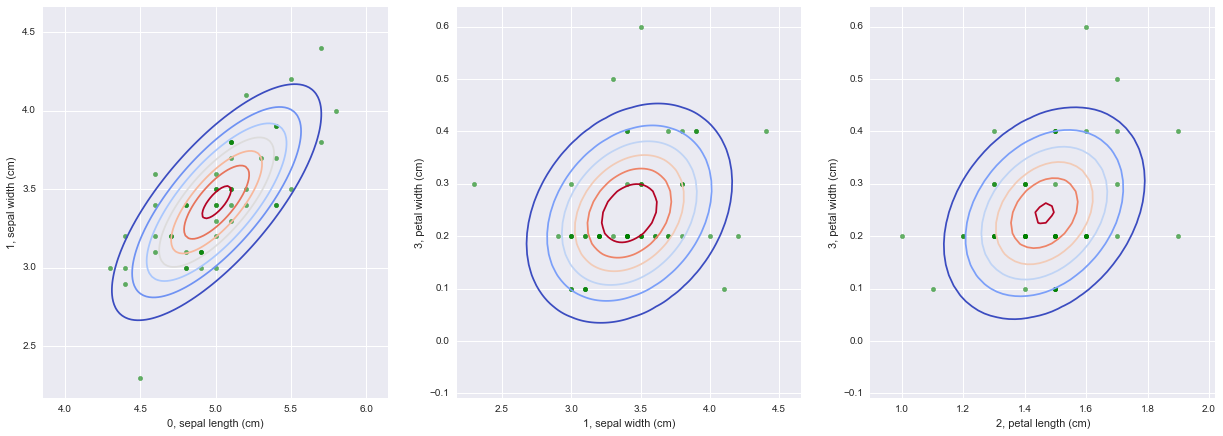

In [14]:
densities(0)


versicolor , coordinates on the graphs.


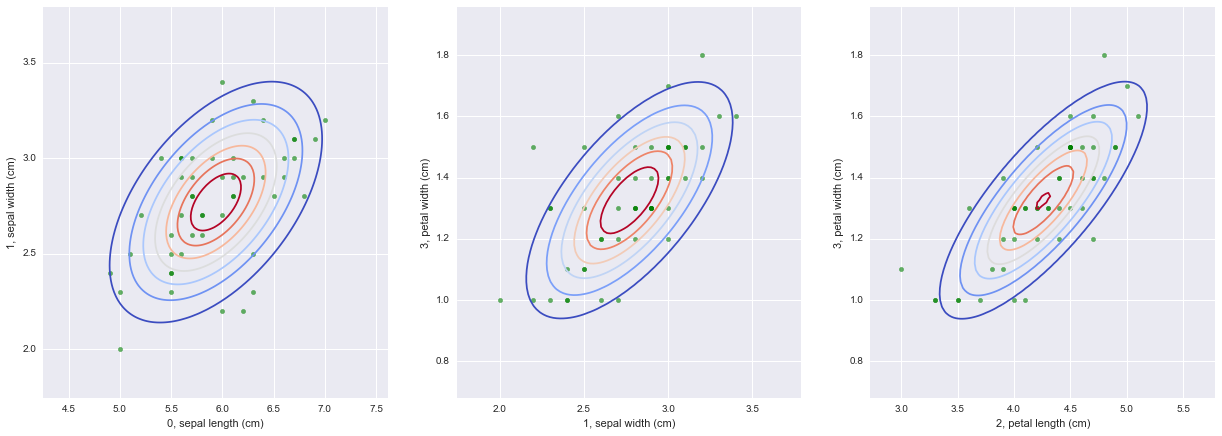

In [15]:
densities(1)

virginica , coordinates on the graphs.


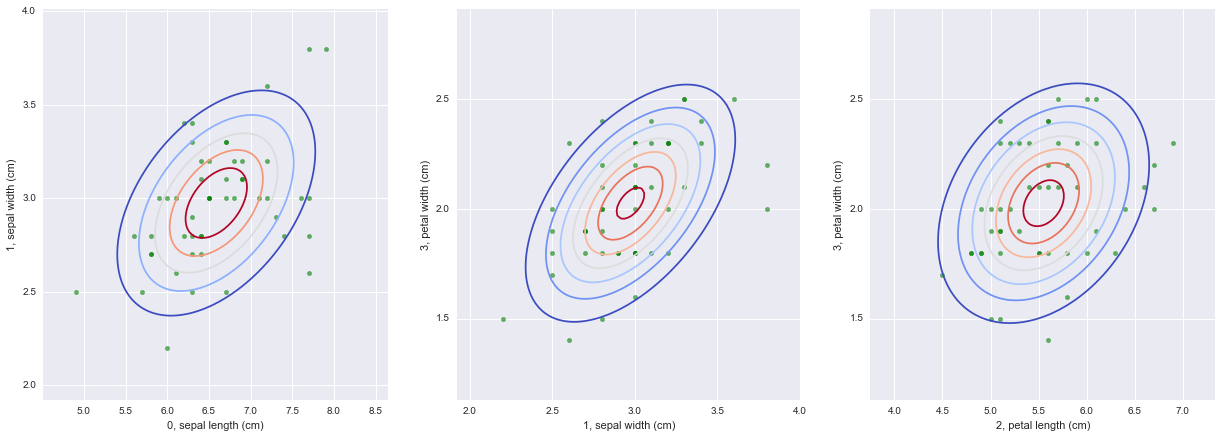

In [16]:
densities(2)

**Таким образом, видим, что построенные нами распределения неплохо описывают выборку.**

**Оценим вероятности $P(T = k)$ частотами вхождений $k$-ых компонент смеси в данную выборку. На основе полученных оценок вычислим математическое ожидание $E(X| T \neq k)$ для всех $k=1,2,3$. Для пар координат $(0,1), (1,3), (2,3)$ получим новые оценки(распределения T) и построим графики условной плотности $p_{(X| I\{ T \neq k \})}(x|1)$**

In [17]:
# Оценим вероятности компонент их частотами.
# Из структуры датасета это 1/3 для каждой компоненты.
frequency = [1./3, 1./3, 1./3]
print("Вероятность компоненты 1:", frequency[0])
print("Вероятность компоненты 2:", frequency[1])
print("Вероятность компоненты 3:", frequency[2])

Вероятность компоненты 1: 0.3333333333333333
Вероятность компоненты 2: 0.3333333333333333
Вероятность компоненты 3: 0.3333333333333333


### $E(X|T \neq k) = \int _ \Re \frac{x p_{(X, I(T \neq k))}(x, k)}{P(T \neq k)} dx = \frac{1}{P(T \neq k)} \int _ \Re x(p_{(X, I(T = (k+1)mod3))}(x, (k+1)mod3)) + p_{(X, I(T = (k+2)mod3))}(x, (k+2)mod3) = \frac{1}{2} (e_{(k+1)mod3} + e_{(k+2)mod3}) $, где $e_i$ - матожидание $i$-й компоненты, так как $P(T=k) = \frac{1}{3}$

(Вообще, странное условное матожидание, оно получается функцией от матожиданий других компонент)

In [50]:
# Найдем эти матожидания.
means_nd = np.array(means)
def get_expect(ind):
    return 1. / 2 * (means_nd[(ind + 1) % 3] + means_nd[(ind + 2) % 3])
indices = np.array([0, 1, 2])
expectations = get_expect(indices)
print("Полученные матожидания, в порядке следования компонент: \n", expectations)
print("Сравним со старыми матожиданиями: \n", means_nd)

Полученные матожидания, в порядке следования компонент: 
 [[ 6.262  2.872  4.906  1.676]
 [ 5.797  3.196  3.508  1.135]
 [ 5.471  3.094  2.862  0.785]]
Сравним со старыми матожиданиями: 
 [[ 5.006  3.418  1.464  0.244]
 [ 5.936  2.77   4.26   1.326]
 [ 6.588  2.974  5.552  2.026]]


### Будем, оценивать условную плотность $p_{(X| I\{ T \neq k \})}(x|1)=p_k(x)(1-1) + \frac{1}{2}(\sum_{i = \{ 0,1,2 \} \setminus k} p_i(x) )$

In [71]:
def get_parameters_n(means_, covars_, number, coord_1, coord_2):
    return ([means_[number][coord_1], means_[number][coord_2]],
        [[covars_[number][coord_1][coord_1], covars_[number][coord_1][coord_2]],
        [covars_[number][coord_2][coord_1], covars_[number][coord_2][coord_2]]])

# Построим графики условной плотности.
def get_conditional_density(number):
    plt.figure(figsize=(21,7))
    print(iris.target_names[number], ', Conditional densities, coordinates on the graphs.')
    # Номер сабплота.
    counter = 1
    for pair in coordinates:
        cur_mean_1, cur_var_1 = get_parameters_n(means, covars, (number + 1) % 3, pair[0], pair[1])
        cur_mean_2, cur_var_2 = get_parameters_n(means, covars, (number + 2) % 3, pair[0], pair[1])
        distr_1 = stats.multivariate_normal(mean=cur_mean_1, cov = cur_var_1)
        distr_2 = stats.multivariate_normal(mean=cur_mean_1, cov = cur_var_2)
        
        ax_ = plt.subplot(1,3,counter)
        counter += 1
        
        # Линии уровня.
        sigma_1 = np.sqrt(max(cur_var_1[0][0], cur_var_2[0][0]))
        sigma_2 = np.sqrt(max(cur_var_1[1][1], cur_var_2[1][1]))
        X = np.arange(cur_mean_1[0] - 3 * sigma_1, cur_mean_1[0] + 3 * sigma_1, 0.02)
        Y = np.arange(cur_mean_1[1] - 3 * sigma_2, cur_mean_1[1] + 3 * sigma_2, 0.02)
        X, Y = np.meshgrid(X, Y)
        # Не до конца понятно, что от нас хотят(эту ли плотность).
        Z = np.vectorize(lambda x, y: (distr_1.pdf([x, y]) + distr_2.pdf([x,y])) / 2. )(X, Y)
        C = plt.contour(X, Y, Z, cmap=cm.coolwarm)
        plt.clabel(C, inline=1, fontsize=10)
        
        plt.ylabel(str(pair[1]) + ', ' + str(iris.feature_names[pair[1]]))
        plt.xlabel(str(pair[0]) + ', ' + str(iris.feature_names[pair[0]]))

setosa , Conditional densities, coordinates on the graphs.


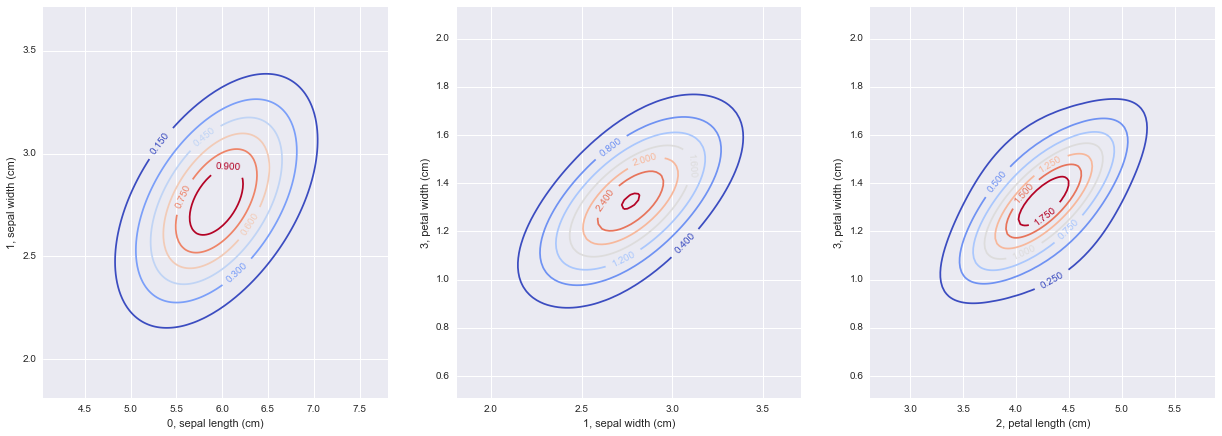

In [72]:
get_conditional_density(0)

versicolor , Conditional densities, coordinates on the graphs.


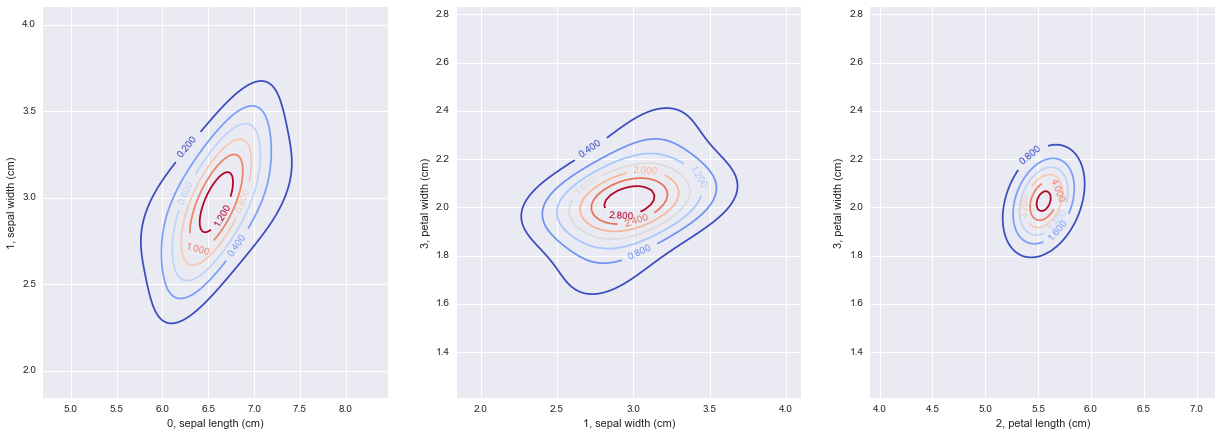

In [73]:
get_conditional_density(1)

virginica , Conditional densities, coordinates on the graphs.


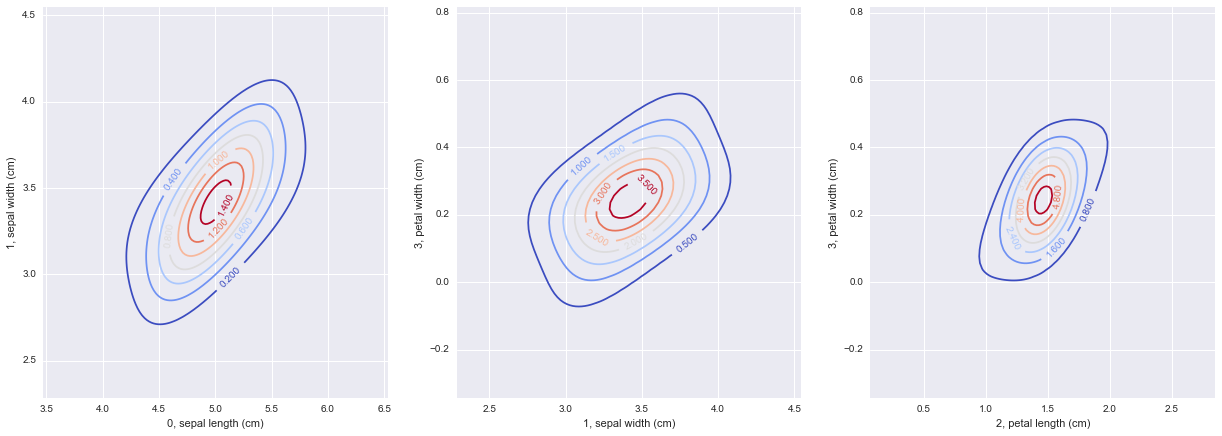

In [74]:
get_conditional_density(2)

Как видим, плотности изменились, в сравнении с теми, которые мы строили вначале.

### Классифицируем все пространство четырехмерных векторов по принципу $k = argmax p_{(X|I\{T = k\}}(x|1) $(в условии явная ошибка и я поменял $\neq$ на $=$) (Так же можно было поменять max на min, но в идеале мы должны получить те же результаты, а так будет точнее и быстрее). Посчитаем долю ошибок. Нарисуем классификацию всего пространства в проекции на указанные координат и раскрасим разными цветами области, которые получатся в результате разбиения.

### Аналогично предыдущему $p_{X|I(T=k)}(x|y) = p_k(x)y + \frac{1}{2}(\sum_{i \in \{ 1,2,3 \} \setminus k }p_i(x))(1 - y)$

### $ p_{X|I{T=k}}(x|1) = p_k(x)$.
Теперь все выглядит логично.

In [85]:
# Посчитаем ошибку.
pdfs = [stats.multivariate_normal(mean=mean_, cov=cov_).pdf for mean_, cov_ in zip(means,covars)]

estimate = lambda x: np.argmax([pdf(x) for pdf in pdfs])
errors = 0
for i, j in zip(iris.data, iris.target):
    if estimate(i) != j:
        errors += 1
error_rate = errors / 150.
print("Доля ошибок нашего классификатора:",100 * error_rate,"%")

Доля ошибок нашего классификатора: 2.0 %


Как и ожидалось, наш классификатор работает хорошо.

Теперь нарисуем классификацию по проекциям.

In [169]:
def get_coloration():
    print("Красные точки:",iris.target_names[0], "Голубые точки:", iris.target_names[1], "Зеленые точки:", iris.target_names[2])
    for i,pair in enumerate(coordinates):
        plt.figure(figsize=(10,5))
        plt.title("Классификация в проекции на указанные координаты")
        grid = np.mgrid[iris.data[:, pair[0]].min():iris.data[:, pair[0]].max():0.02,
                        iris.data[:, pair[1]].min():iris.data[:, pair[1]].max():0.02] 
        
        pdfs = []
        for i in range(0,3):
            mean_, cov_ = get_parameters_n(means, covars, i, pair[0], pair[1])
            pdfs.append(stats.multivariate_normal(mean=mean_, cov=cov_).pdf) 
        estimate = lambda x: np.argmax([pdf(x) for pdf in pdfs], axis=0)
        plt.pcolormesh(grid[0], grid[1], estimate(np.dstack((grid[0], grid[1]))), cmap=cm.Set3)
        colors = ['r','b','g']
        for ind in range(3):
            plt.scatter(iris.data[iris.target==ind, pair[0]], iris.data[iris.target==ind,pair[1]],c=colors[ind])
        plt.ylabel(str(pair[1]) + ', ' + str(iris.feature_names[pair[1]]))
        plt.xlabel(str(pair[0]) + ', ' + str(iris.feature_names[pair[0]]))
        plt.show()

Красные точки: setosa Голубые точки: versicolor Зеленые точки: virginica


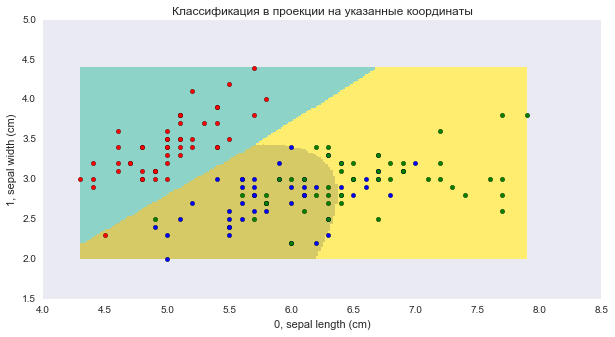

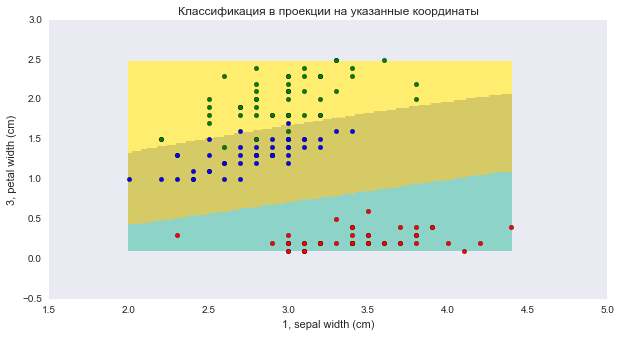

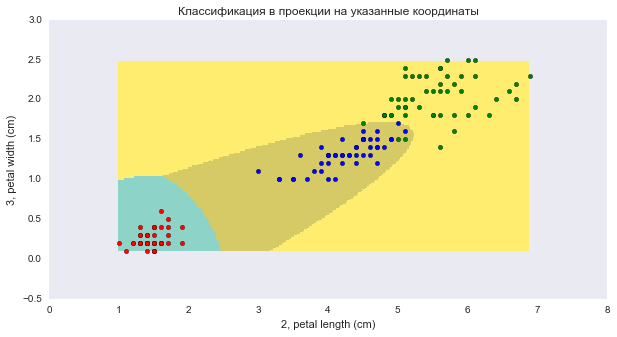

In [170]:
get_coloration()

### Вывод. Мы построили классификатор, который с маленькой ошибкой в 2 процента, хорошо разделяет нашу выборку. Значит модель смеси гауссовских распределений оказалась подходящей для этой задачи. Так же мы рассмотрели проекции наших распределений на определенные признаки, и убедились, что в каждой проекции классификация остается верной. Еще мы сравнили плотности полученные с помощью условного математического ожидания с теми, которые получили вначале, они получились более искаженными(условные).